# **Prediction of Bitcoin and Nvidia**

## We need package because they have build in model already. We will use regression model, SVM model, Adaboost model, LSTM model, and will build own multilayer model with tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix

## First, we need collect the data from yahoo finance

In [ ]:
start_date = '2014-09-17'
end_date = '2023-06-01'
bitcoin = yf.download(tickers = 'BTC-USD', start=start_date, end=end_date)
nvda = yf.download(tickers = 'NVDA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## This is the original dataframe, and we may need to clean it

In [ ]:
print(bitcoin.head())
print(nvda.head())
print(bitcoin.info())
print(nvda.info())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
              Open    High     Low   Close  Adj Close    Volume
Date                                                           
2014-09-17  4.7725  4.8325  4.7500  4.7875   4.578933  17358400
2014-09-18  4.8175  4.8650  4.8025  4.8600   4.648273  21960400
2014-09-19  4.8750  4.8800  4.7625  4.7700   4.562193  60131600


## Only two parameters are retained, adjusted close and volume. adj close is retained because nvda is a traded asset, it will be divided and split, if not adjusted, the price will be broken. The other data will not only make the operation slower, but will also generate a lot of noise

In [ ]:
column = ['Adj Close','Volume']
bitcoin = bitcoin[column]
nvda = nvda[column]
scale = MinMaxScaler(feature_range=(0, 1))
bitcoin[['Adj Close', 'Volume']] = scale.fit_transform(bitcoin[['Adj Close', 'Volume']])
nvda[['Adj Close', 'Volume']] = scale.fit_transform(nvda[['Adj Close', 'Volume']])

<ipython-input-4-0aee279d3e84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin[['Adj Close', 'Volume']] = scale.fit_transform(bitcoin[['Adj Close', 'Volume']])
<ipython-input-4-0aee279d3e84>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda[['Adj Close', 'Volume']] = scale.fit_transform(nvda[['Adj Close', 'Volume']])


In [ ]:
print(bitcoin.head())
print(nvda.info())

            Adj Close    Volume
Date                           
2014-09-17   0.004144  0.000043
2014-09-18   0.003655  0.000081
2014-09-19   0.003216  0.000091
2014-09-20   0.003425  0.000088
2014-09-21   0.003275  0.000059
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2014-09-17 to 2023-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2191 non-null   float64
 1   Volume     2191 non-null   float64
dtypes: float64(2)
memory usage: 51.4 KB
None


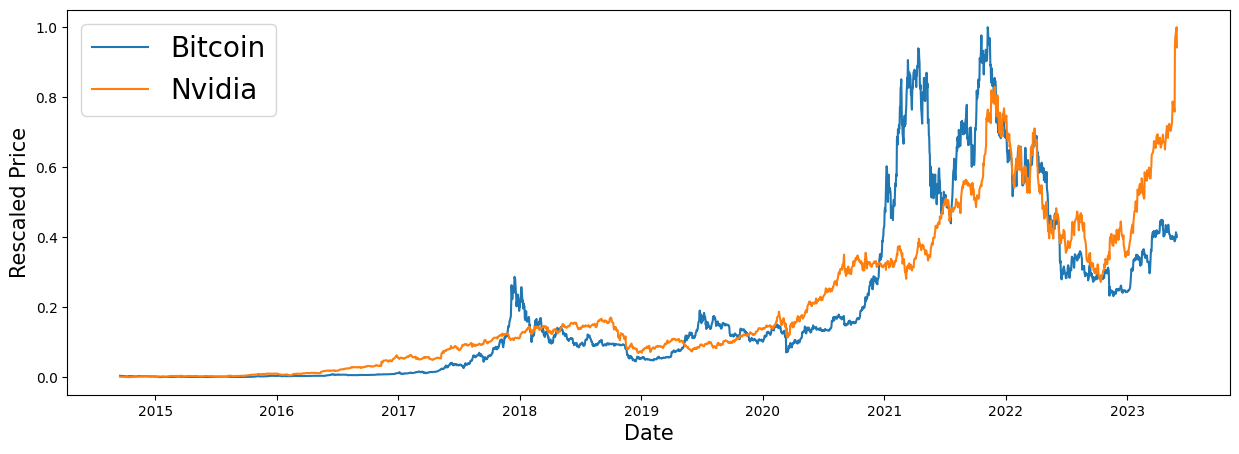

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(bitcoin['Adj Close'], label='Bitcoin')
plt.plot(nvda['Adj Close'], label='Nvidia')
plt.legend(loc='best',fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Rescaled Price',fontsize = 15)
plt.show()

## the line graph looks similar, we will try to calculate the correlation with pearson method

In [ ]:
correlation = bitcoin['Adj Close'].corr(nvda['Adj Close'],method='pearson')
print('correlation betweeb bitcoin and nvda:'+ str(correlation))

correlation betweeb bitcoin and nvda:0.8598124727226197


## so they are high correlated, maybe we can try to predict one with the model trained by the other one

## we need split the dataset for training validation and test

In [ ]:
time_window = 100
classes = ['buy','sell']
buy = classes.index('buy')
sell = classes.index('sell')
xb,yb = [],[]
xn,yn = [],[]
for i in range(len(bitcoin)):
    past_data = bitcoin[:i+1]
    forward_data = bitcoin[i+1:]
    if len(past_data) <time_window or len(forward_data) <1:
        continue
    past_data_win = past_data[-time_window:]
    forward_data_win = forward_data[:1]
    today = past_data_win.iloc[-1]['Adj Close']
    tomorrow = forward_data_win.iloc[0]['Adj Close']
    label = buy if tomorrow > today else sell
    xb.append(past_data_win.values)
    yb.append(label)
for i in range(len(nvda)):
    past_data = nvda[:i+1]
    forward_data = nvda[i+1:]
    if len(past_data) <time_window or len(forward_data) <1:
        continue
    past_data_win = past_data[-time_window:]
    forward_data_win = forward_data[:1]
    today = past_data_win.iloc[-1]['Adj Close']
    tomorrow = forward_data_win.iloc[0]['Adj Close']
    label = buy if tomorrow > today else sell
    xn.append(past_data_win.values)
    yn.append(label)

xb,yb = np.array(xb), np.array(yb)
xn,yn = np.array(xn), np.array(yn)
Xb_train_val, Xb_test, Yb_train_val, Yb_test = train_test_split(xb, yb, test_size=0.1, shuffle=False)
Xb_train, Xb_val, Yb_train, Yb_val = train_test_split(Xb_train_val, Yb_train_val, test_size=0.2, shuffle=True)

Xn_train_val, Xn_test, Yn_train_val, Yn_test = train_test_split(xn, yn, test_size=0.1, shuffle=False)
Xn_train, Xn_val, Yn_train, Yn_val = train_test_split(Xn_train_val, Yn_train_val, test_size=0.2, shuffle=True)

## we will train the regression model first.

In [ ]:
Xb_train_val_flat = Xb_train_val.reshape(Xb_train_val.shape[0], -1)
Xn_train_val_flat = Xn_train_val.reshape(Xn_train_val.shape[0], -1)
Xb_test_flat = Xb_test.reshape(Xb_test.shape[0], -1)
Xn_test_flat = Xn_test.reshape(Xn_test.shape[0], -1)
model_b = LogisticRegression()
model_n = LogisticRegression()
model_b.fit(Xb_train_val_flat, Yb_train_val)
model_n.fit(Xn_train_val_flat, Yn_train_val)
pred_b_val = model_b.predict(Xb_test_flat)
pred_n_val = model_n.predict(Xn_test_flat)
accuracy_b_val = accuracy_score(Yb_test, pred_b_val)
accuracy_n_val = accuracy_score(Yn_test, pred_n_val)

print("accuracy of regression model on bitcoin:", accuracy_b_val)
print("accuracy of regression model on NVDA:", accuracy_n_val)


accuracy of regression model on bitcoin: 0.5097402597402597
accuracy of regression model on NVDA: 0.48095238095238096


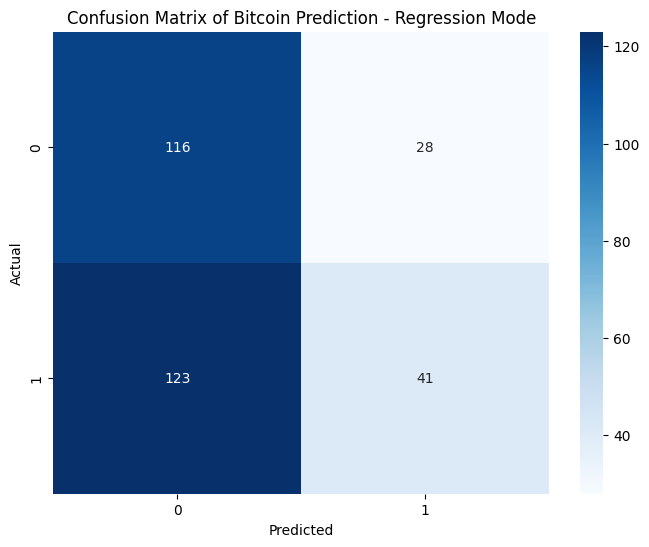

In [ ]:

cm_b = confusion_matrix(Yb_test, pred_b_val)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Bitcoin Prediction - Regression Mode")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The accuracy looks really low, that means regression may not be a good model, anyway, we will try to predict each other.

In [ ]:
pred_b_val = model_b.predict(Xn_test_flat)
pred_n_val = model_n.predict(Xb_test_flat)
accuracy_b_to_n_val = accuracy_score(Yn_test, pred_b_val)
accuracy_n_to_b_val = accuracy_score(Yb_test, pred_n_val)

print("accuracy of bitcoin regression model to predict NVDA:", accuracy_b_to_n_val)
print("accuracy of NVDA regression model to predict bitcoin:", accuracy_n_to_b_val)

accuracy of bitcoin regression model to predict NVDA: 0.5190476190476191
accuracy of NVDA regression model to predict bitcoin: 0.525974025974026


funny, the model run better on test, if such things happen on all model, the the dataset is biased

## let's try SVM this time

In [ ]:
svcmodel_b = SVC()
svcmodel_n = SVC()

svcmodel_b.fit(Xb_train_val_flat, Yb_train_val)
svcmodel_n.fit(Xn_train_val_flat, Yn_train_val)

pred_b = svcmodel_b.predict(Xb_test_flat)
pred_n = svcmodel_n.predict(Xn_test_flat)

accuracy_b_val = accuracy_score(Yb_test, pred_b)
accuracy_n_val = accuracy_score(Yn_test, pred_n)
print("accuracy of SVC model on bitcoin:", accuracy_b_val)
print("accuracy of SVC model on NVDA:", accuracy_n_val)

accuracy of SVC model on bitcoin: 0.4772727272727273
accuracy of SVC model on NVDA: 0.5285714285714286


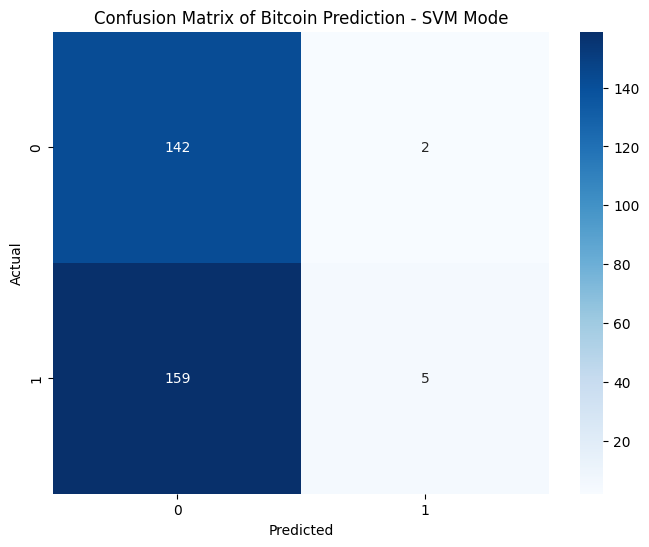

In [ ]:
cm_b = confusion_matrix(Yb_test, pred_b)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Bitcoin Prediction - SVM Mode")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

looks better than regression model, and again, test each other

In [ ]:
pred_b_val = svcmodel_b.predict(Xn_test_flat)
pred_n_val = svcmodel_n.predict(Xb_test_flat)
accuracy_b_to_n_val = accuracy_score(Yn_test, pred_b_val)
accuracy_n_to_b_val = accuracy_score(Yb_test, pred_n_val)

print("accuracy of bitcoin SVC model to predict NVDA:", accuracy_b_to_n_val)
print("accuracy of NVDA SVC model to predict bitcoin:", accuracy_n_to_b_val)

accuracy of bitcoin SVC model to predict NVDA: 0.5428571428571428
accuracy of NVDA SVC model to predict bitcoin: 0.4675324675324675


one accuracy is higher, and one is lower, now we can confirm that the data is biased

## How about Adaboost

In [ ]:
adamodel_b = AdaBoostClassifier()
adamodel_n = AdaBoostClassifier()

adamodel_b.fit(Xb_train_val_flat, Yb_train_val)
adamodel_n.fit(Xn_train_val_flat, Yn_train_val)

pred_b_val = adamodel_b.predict(Xb_test_flat)
pred_n_val = adamodel_n.predict(Xn_test_flat)

accuracy_b_val = accuracy_score(Yb_test, pred_b_val)
accuracy_n_val = accuracy_score(Yn_test, pred_n_val)

print("Accuracy of AdaBoost model on bitcoin:", accuracy_b_val)
print("Accuracy of AdaBoost model on NVDA:", accuracy_n_val)

Accuracy of AdaBoost model on bitcoin: 0.4707792207792208
Accuracy of AdaBoost model on NVDA: 0.41904761904761906


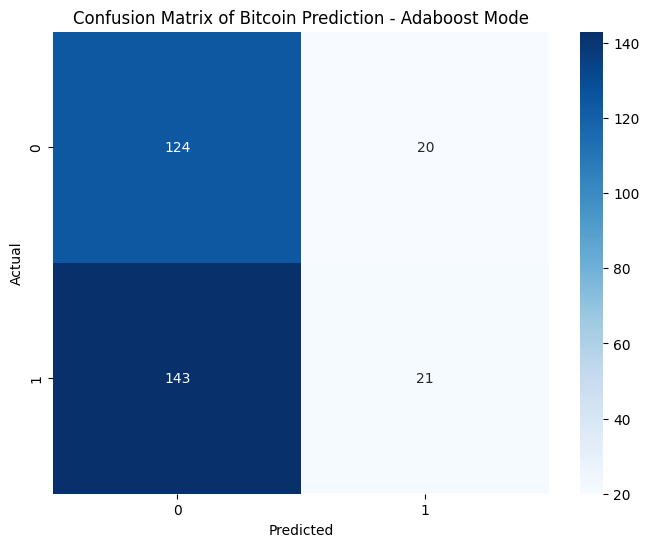

In [ ]:
cm_b = confusion_matrix(Yb_test, pred_b_val)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Bitcoin Prediction - Adaboost Mode")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
pred_b_val = adamodel_b.predict(Xn_test_flat)
pred_n_val = adamodel_n.predict(Xb_test_flat)
accuracy_b_to_n_val = accuracy_score(Yn_test, pred_b_val)
accuracy_n_to_b_val = accuracy_score(Yb_test, pred_n_val)

print("accuracy of bitcoin AdaBoost model to predict NVDA:", accuracy_b_to_n_val)
print("accuracy of NVDA AdaBoost model to predict bitcoin:", accuracy_n_to_b_val)

accuracy of bitcoin AdaBoost model to predict NVDA: 0.5619047619047619
accuracy of NVDA AdaBoost model to predict bitcoin: 0.5422077922077922


looks like the standard error is really high on this model

## LSMN is my last sigle model,almost done

In [ ]:
model_b = Sequential()
model_b.add(LSTM(units=64, input_shape=(time_window, 2)))
model_b.add(Dense(units=1, activation='sigmoid'))
model_n = Sequential()
model_n.add(LSTM(units=64, input_shape=(time_window, 2)))
model_n.add(Dense(units=1, activation='sigmoid'))
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_n.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_b.fit(Xb_train, Yb_train, epochs=10, batch_size=32, validation_data=(Xb_val, Yb_val))
model_n.fit(Xn_train, Yn_train, epochs=10, batch_size=32, validation_data=(Xn_val, Yn_val))

accuracy_b_val = model_b.evaluate(Xb_test, Yb_test)[1]
accuracy_n_val = model_n.evaluate(Xn_test, Yn_test)[1]
print("accuracy of LSTM model on bitcoin:", accuracy_b_val)
print("accuracy of LSTM model on NVDA:", accuracy_n_val)

Epoch 1/10
70/70 [==============================] - 7s 60ms/step - loss: 0.6919 - accuracy: 0.5343 - val_loss: 0.6903 - val_accuracy: 0.5477
Epoch 2/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6917 - accuracy: 0.5293 - val_loss: 0.6855 - val_accuracy: 0.5784
Epoch 3/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6907 - accuracy: 0.5343 - val_loss: 0.6866 - val_accuracy: 0.5658
Epoch 4/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6904 - accuracy: 0.5311 - val_loss: 0.6857 - val_accuracy: 0.5676
Epoch 5/10
70/70 [==============================] - 5s 72ms/step - loss: 0.6909 - accuracy: 0.5352 - val_loss: 0.6854 - val_accuracy: 0.5712
Epoch 6/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6902 - accuracy: 0.5356 - val_loss: 0.6854 - val_accuracy: 0.5730
Epoch 7/10
70/70 [==============================] - 4s 52ms/step - loss: 0.6900 - accuracy: 0.5384 - val_loss: 0.6844 - val_accuracy: 0.5730
Epoch 8/10
70

The accuracy of this model is not outstanding

## now we are going to build a multilayer perceptron model

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6969 - accuracy: 0.5093 - val_loss: 0.6993 - val_accuracy: 0.5623
Epoch 2/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.7046 - accuracy: 0.5406 - val_loss: 0.6890 - val_accuracy: 0.5623
Epoch 3/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.6934 - accuracy: 0.5406 - val_loss: 0.6855 - val_accuracy: 0.5597
Epoch 4/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.6882 - accuracy: 0.5419 - val_loss: 0.6912 - val_accuracy: 0.5597
Epoch 5/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.6918 - accuracy: 0.5286 - val_loss: 0.6922 - val_accuracy: 0.5517
Epoch 6/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.6916 - accuracy: 0.5386 - val_loss: 0.6885 - val_accuracy: 0.5703
Epoch 7/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.6878 - accuracy: 0.5359 - val_loss: 0.6860 - val_accuracy: 0.5570
Epoch 8/1000
1/

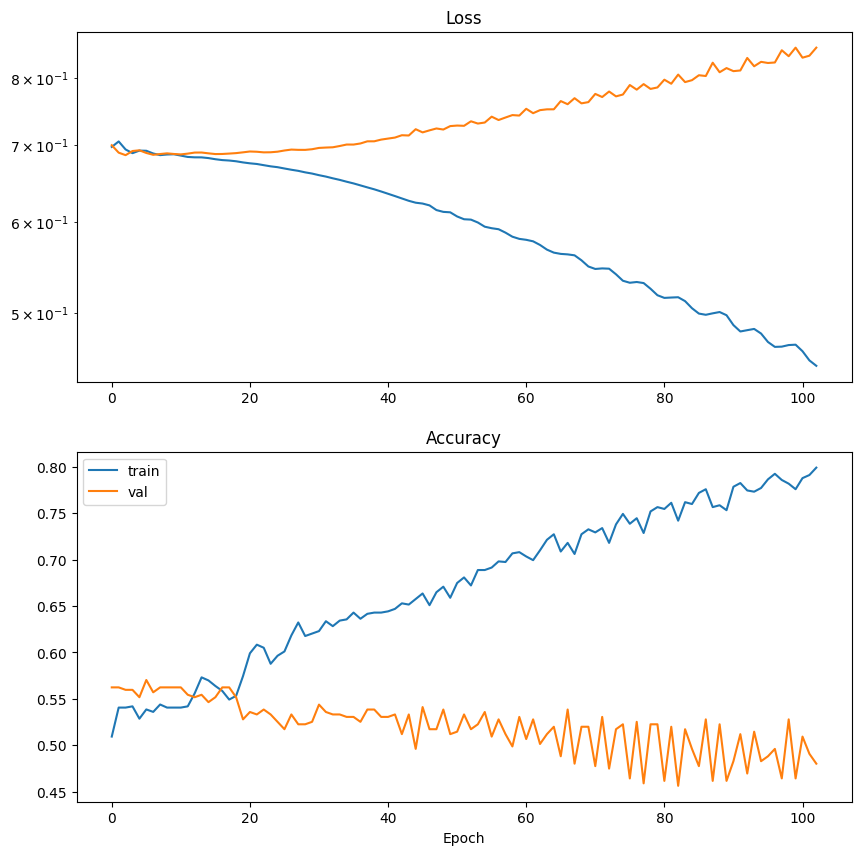

In [ ]:
n_time_steps = Xn_train.shape[1]
n_features = Xn_train.shape[2]
input_layer = Input(shape=(n_time_steps, n_features))
x = Flatten()(input_layer)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(2, activation='softmax')(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.summary
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]
train_history = model.fit(Xn_train, to_categorical(Yn_train), epochs=1000, batch_size=2048, validation_data=(Xn_val, to_categorical(Yn_val)), callbacks=callbacks)
fig,axes = plt.subplots(2,1,figsize=(10,10))
axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[0].plot(train_history.history['loss'], label='train')
axes[0].plot(train_history.history['val_loss'], label='val')
axes[1].set_title('Accuracy')
axes[1].plot(train_history.history['accuracy'], label='train')
axes[1].plot(train_history.history['val_accuracy'], label='val')
axes[1].set_xlabel('Epoch')
plt.legend()

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.hdf5')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(Xn_test, to_categorical(Yn_test))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

7/7 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5143
Test Loss: 0.6932830214500427
Test Accuracy: 0.5142857432365417


## Robustness analysis: The entire workflow, including data preparation, model training, evaluation, and visualization, will be repeated 100 times.

In [ ]:
n_runs = 100
model_names = ['Logistic Regression', 'SVM', 'AdaBoost', 'LSTM', 'Multilayer Perceptron']
accuracy_models = {model_name: [] for model_name in model_names}

for run in range(n_runs):
    # Re-split the data into train, validation, and test sets
    Xb_train_val, Xb_test, Yb_train_val, Yb_test = train_test_split(xb, yb, test_size=0.1, shuffle=True)
    Xb_train, Xb_val, Yb_train, Yb_val = train_test_split(Xb_train_val, Yb_train_val, test_size=0.2, shuffle=True)

    Xb_train_val_flat = Xb_train_val.reshape(Xb_train_val.shape[0], -1)
    Xb_test_flat = Xb_test.reshape(Xb_test.shape[0], -1)

    # Logistic Regression
    model_b = LogisticRegression()
    model_b.fit(Xb_train_val_flat, Yb_train_val)
    pred_b_val = model_b.predict(Xb_test_flat)
    accuracy_b_val = accuracy_score(Yb_test, pred_b_val)
    accuracy_models['Logistic Regression'].append(accuracy_b_val)

    # Support Vector Machine (SVM)
    svcmodel_b = SVC()
    svcmodel_b.fit(Xb_train_val_flat, Yb_train_val)
    pred_b_val = svcmodel_b.predict(Xb_test_flat)
    accuracy_b_val = accuracy_score(Yb_test, pred_b_val)
    accuracy_models['SVM'].append(accuracy_b_val)

    # AdaBoost
    adamodel_b = AdaBoostClassifier()
    adamodel_b.fit(Xb_train_val_flat, Yb_train_val)
    pred_b_val = adamodel_b.predict(Xb_test_flat)
    accuracy_b_val = accuracy_score(Yb_test, pred_b_val)
    accuracy_models['AdaBoost'].append(accuracy_b_val)

    # LSTM
    model_b = Sequential()
    model_b.add(LSTM(units=64, input_shape=(time_window, 2)))
    model_b.add(Dense(units=1, activation='sigmoid'))
    model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_b.fit(Xb_train, Yb_train, epochs=10, batch_size=32, validation_data=(Xb_val, Yb_val))
    accuracy_b_val = model_b.evaluate(Xb_test, Yb_test)[1]
    accuracy_models['LSTM'].append(accuracy_b_val)

    # Multilayer Perceptron
    model_b = Sequential()
    model_b.add(Flatten(input_shape=(time_window, 2)))
    model_b.add(Dense(256, activation='relu'))
    model_b.add(Dense(256, activation='relu'))
    model_b.add(Dense(1, activation='sigmoid'))
    model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_b.fit(Xb_train, Yb_train, epochs=10, batch_size=32, validation_data=(Xb_val, Yb_val))
    accuracy_b_val = model_b.evaluate(Xb_test, Yb_test)[1]
    accuracy_models['Multilayer Perceptron'].append(accuracy_b_val)


Epoch 1/10
70/70 [==============================] - 9s 79ms/step - loss: 0.6917 - accuracy: 0.5311 - val_loss: 0.6886 - val_accuracy: 0.5369
Epoch 2/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6911 - accuracy: 0.5253 - val_loss: 0.6918 - val_accuracy: 0.5604
Epoch 3/10
70/70 [==============================] - 4s 52ms/step - loss: 0.6910 - accuracy: 0.5311 - val_loss: 0.6887 - val_accuracy: 0.5387
Epoch 4/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6908 - accuracy: 0.5262 - val_loss: 0.6883 - val_accuracy: 0.5387
Epoch 5/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6908 - accuracy: 0.5334 - val_loss: 0.6883 - val_accuracy: 0.5387
Epoch 6/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6906 - accuracy: 0.5325 - val_loss: 0.6885 - val_accuracy: 0.5369
Epoch 7/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6909 - accuracy: 0.5289 - val_loss: 0.6882 - val_accuracy: 0.5423
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 85ms/step - loss: 0.6928 - accuracy: 0.5190 - val_loss: 0.6899 - val_accuracy: 0.5387
Epoch 2/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6919 - accuracy: 0.5289 - val_loss: 0.6910 - val_accuracy: 0.5459
Epoch 3/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6913 - accuracy: 0.5307 - val_loss: 0.6885 - val_accuracy: 0.5459
Epoch 4/10
70/70 [==============================] - 5s 72ms/step - loss: 0.6911 - accuracy: 0.5343 - val_loss: 0.6899 - val_accuracy: 0.5459
Epoch 5/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6914 - accuracy: 0.5271 - val_loss: 0.6899 - val_accuracy: 0.5532
Epoch 6/10
70/70 [==============================] - 4s 54ms/step - loss: 0.6910 - accuracy: 0.5384 - val_loss: 0.6881 - val_accuracy: 0.5369
Epoch 7/10
70/70 [==============================] - 5s 72ms/step - loss: 0.6912 - accuracy: 0.5271 - val_loss: 0.6883 - val_accuracy: 0.5387
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 9s 92ms/step - loss: 0.6916 - accuracy: 0.5293 - val_loss: 0.6908 - val_accuracy: 0.5207
Epoch 2/10
70/70 [==============================] - 5s 75ms/step - loss: 0.6905 - accuracy: 0.5352 - val_loss: 0.6895 - val_accuracy: 0.5441
Epoch 3/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6905 - accuracy: 0.5329 - val_loss: 0.6898 - val_accuracy: 0.5459
Epoch 4/10
70/70 [==============================] - 6s 81ms/step - loss: 0.6901 - accuracy: 0.5361 - val_loss: 0.6896 - val_accuracy: 0.5459
Epoch 5/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6904 - accuracy: 0.5379 - val_loss: 0.6894 - val_accuracy: 0.5333
Epoch 6/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6904 - accuracy: 0.5307 - val_loss: 0.6897 - val_accuracy: 0.5477
Epoch 7/10
70/70 [==============================] - 5s 76ms/step - loss: 0.6901 - accuracy: 0.5338 - val_loss: 0.6895 - val_accuracy: 0.5477
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 86ms/step - loss: 0.6911 - accuracy: 0.5469 - val_loss: 0.6903 - val_accuracy: 0.5369
Epoch 2/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6907 - accuracy: 0.5352 - val_loss: 0.6896 - val_accuracy: 0.5423
Epoch 3/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6911 - accuracy: 0.5217 - val_loss: 0.6884 - val_accuracy: 0.5423
Epoch 4/10
70/70 [==============================] - 5s 74ms/step - loss: 0.6904 - accuracy: 0.5366 - val_loss: 0.6882 - val_accuracy: 0.5441
Epoch 5/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6904 - accuracy: 0.5356 - val_loss: 0.6884 - val_accuracy: 0.5387
Epoch 6/10
70/70 [==============================] - 4s 54ms/step - loss: 0.6902 - accuracy: 0.5361 - val_loss: 0.6880 - val_accuracy: 0.5423
Epoch 7/10
70/70 [==============================] - 5s 73ms/step - loss: 0.6902 - accuracy: 0.5343 - val_loss: 0.6879 - val_accuracy: 0.5441
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 71ms/step - loss: 0.6927 - accuracy: 0.5135 - val_loss: 0.6902 - val_accuracy: 0.5333
Epoch 2/10
70/70 [==============================] - 5s 78ms/step - loss: 0.6909 - accuracy: 0.5379 - val_loss: 0.6896 - val_accuracy: 0.5315
Epoch 3/10
70/70 [==============================] - 4s 64ms/step - loss: 0.6909 - accuracy: 0.5311 - val_loss: 0.6893 - val_accuracy: 0.5297
Epoch 4/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6903 - accuracy: 0.5393 - val_loss: 0.6894 - val_accuracy: 0.5297
Epoch 5/10
70/70 [==============================] - 6s 83ms/step - loss: 0.6905 - accuracy: 0.5361 - val_loss: 0.6904 - val_accuracy: 0.5279
Epoch 6/10
70/70 [==============================] - 5s 65ms/step - loss: 0.6902 - accuracy: 0.5347 - val_loss: 0.6895 - val_accuracy: 0.5297
Epoch 7/10
70/70 [==============================] - 4s 61ms/step - loss: 0.6907 - accuracy: 0.5316 - val_loss: 0.6904 - val_accuracy: 0.5297
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 71ms/step - loss: 0.6923 - accuracy: 0.5239 - val_loss: 0.6896 - val_accuracy: 0.5423
Epoch 2/10
70/70 [==============================] - 4s 63ms/step - loss: 0.6916 - accuracy: 0.5239 - val_loss: 0.6896 - val_accuracy: 0.5441
Epoch 3/10
70/70 [==============================] - 5s 73ms/step - loss: 0.6907 - accuracy: 0.5302 - val_loss: 0.6888 - val_accuracy: 0.5441
Epoch 4/10
70/70 [==============================] - 4s 60ms/step - loss: 0.6906 - accuracy: 0.5329 - val_loss: 0.6883 - val_accuracy: 0.5459
Epoch 5/10
70/70 [==============================] - 5s 75ms/step - loss: 0.6915 - accuracy: 0.5293 - val_loss: 0.6893 - val_accuracy: 0.5477
Epoch 6/10
70/70 [==============================] - 4s 63ms/step - loss: 0.6909 - accuracy: 0.5302 - val_loss: 0.6885 - val_accuracy: 0.5441
Epoch 7/10
70/70 [==============================] - 5s 77ms/step - loss: 0.6907 - accuracy: 0.5334 - val_loss: 0.6886 - val_accuracy: 0.5477
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 9s 80ms/step - loss: 0.6913 - accuracy: 0.5226 - val_loss: 0.6958 - val_accuracy: 0.5027
Epoch 2/10
70/70 [==============================] - 5s 70ms/step - loss: 0.6899 - accuracy: 0.5429 - val_loss: 0.6917 - val_accuracy: 0.5279
Epoch 3/10
70/70 [==============================] - 4s 64ms/step - loss: 0.6898 - accuracy: 0.5393 - val_loss: 0.6947 - val_accuracy: 0.5045
Epoch 4/10
70/70 [==============================] - 5s 70ms/step - loss: 0.6899 - accuracy: 0.5329 - val_loss: 0.6934 - val_accuracy: 0.5153
Epoch 5/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6903 - accuracy: 0.5329 - val_loss: 0.6918 - val_accuracy: 0.5225
Epoch 6/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6894 - accuracy: 0.5347 - val_loss: 0.6936 - val_accuracy: 0.5153
Epoch 7/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6898 - accuracy: 0.5384 - val_loss: 0.6926 - val_accuracy: 0.5135
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 7s 71ms/step - loss: 0.6916 - accuracy: 0.5343 - val_loss: 0.6886 - val_accuracy: 0.5387
Epoch 2/10
70/70 [==============================] - 5s 67ms/step - loss: 0.6911 - accuracy: 0.5302 - val_loss: 0.6884 - val_accuracy: 0.5532
Epoch 3/10
70/70 [==============================] - 4s 60ms/step - loss: 0.6908 - accuracy: 0.5325 - val_loss: 0.6882 - val_accuracy: 0.5405
Epoch 4/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6909 - accuracy: 0.5325 - val_loss: 0.6882 - val_accuracy: 0.5405
Epoch 5/10
70/70 [==============================] - 5s 70ms/step - loss: 0.6916 - accuracy: 0.5298 - val_loss: 0.6880 - val_accuracy: 0.5495
Epoch 6/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6905 - accuracy: 0.5361 - val_loss: 0.6878 - val_accuracy: 0.5532
Epoch 7/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6906 - accuracy: 0.5284 - val_loss: 0.6880 - val_accuracy: 0.5441
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 74ms/step - loss: 0.6917 - accuracy: 0.5379 - val_loss: 0.6923 - val_accuracy: 0.5189
Epoch 2/10
70/70 [==============================] - 4s 51ms/step - loss: 0.6903 - accuracy: 0.5356 - val_loss: 0.6923 - val_accuracy: 0.5135
Epoch 3/10
70/70 [==============================] - 4s 57ms/step - loss: 0.6898 - accuracy: 0.5366 - val_loss: 0.6926 - val_accuracy: 0.5045
Epoch 4/10
70/70 [==============================] - 4s 58ms/step - loss: 0.6900 - accuracy: 0.5375 - val_loss: 0.6926 - val_accuracy: 0.5099
Epoch 5/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6897 - accuracy: 0.5402 - val_loss: 0.6928 - val_accuracy: 0.5063
Epoch 6/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6897 - accuracy: 0.5370 - val_loss: 0.6924 - val_accuracy: 0.5045
Epoch 7/10
70/70 [==============================] - 4s 55ms/step - loss: 0.6898 - accuracy: 0.5411 - val_loss: 0.6928 - val_accuracy: 0.5099
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 73ms/step - loss: 0.6923 - accuracy: 0.5248 - val_loss: 0.6904 - val_accuracy: 0.5279
Epoch 2/10
70/70 [==============================] - 4s 61ms/step - loss: 0.6910 - accuracy: 0.5320 - val_loss: 0.6898 - val_accuracy: 0.5423
Epoch 3/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6909 - accuracy: 0.5266 - val_loss: 0.6895 - val_accuracy: 0.5387
Epoch 4/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6907 - accuracy: 0.5275 - val_loss: 0.6905 - val_accuracy: 0.5315
Epoch 5/10
70/70 [==============================] - 5s 72ms/step - loss: 0.6907 - accuracy: 0.5239 - val_loss: 0.6916 - val_accuracy: 0.5225
Epoch 6/10
70/70 [==============================] - 4s 62ms/step - loss: 0.6906 - accuracy: 0.5338 - val_loss: 0.6899 - val_accuracy: 0.5315
Epoch 7/10
70/70 [==============================] - 5s 67ms/step - loss: 0.6907 - accuracy: 0.5244 - val_loss: 0.6904 - val_accuracy: 0.5297
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 7s 71ms/step - loss: 0.6915 - accuracy: 0.5176 - val_loss: 0.6907 - val_accuracy: 0.5261
Epoch 2/10
70/70 [==============================] - 5s 77ms/step - loss: 0.6893 - accuracy: 0.5429 - val_loss: 0.6936 - val_accuracy: 0.5099
Epoch 3/10
70/70 [==============================] - 5s 64ms/step - loss: 0.6896 - accuracy: 0.5469 - val_loss: 0.6963 - val_accuracy: 0.5009
Epoch 4/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6884 - accuracy: 0.5429 - val_loss: 0.6937 - val_accuracy: 0.5225
Epoch 5/10
70/70 [==============================] - 5s 70ms/step - loss: 0.6885 - accuracy: 0.5397 - val_loss: 0.6950 - val_accuracy: 0.5081
Epoch 6/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6890 - accuracy: 0.5420 - val_loss: 0.6944 - val_accuracy: 0.5063
Epoch 7/10
70/70 [==============================] - 5s 69ms/step - loss: 0.6886 - accuracy: 0.5501 - val_loss: 0.6938 - val_accuracy: 0.5063
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 71ms/step - loss: 0.6912 - accuracy: 0.5280 - val_loss: 0.6994 - val_accuracy: 0.4937
Epoch 2/10
70/70 [==============================] - 5s 69ms/step - loss: 0.6896 - accuracy: 0.5433 - val_loss: 0.6938 - val_accuracy: 0.4991
Epoch 3/10
70/70 [==============================] - 4s 60ms/step - loss: 0.6887 - accuracy: 0.5478 - val_loss: 0.7005 - val_accuracy: 0.4919
Epoch 4/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6888 - accuracy: 0.5442 - val_loss: 0.6981 - val_accuracy: 0.5135
Epoch 5/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6882 - accuracy: 0.5379 - val_loss: 0.6967 - val_accuracy: 0.5009
Epoch 6/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6880 - accuracy: 0.5483 - val_loss: 0.6979 - val_accuracy: 0.4991
Epoch 7/10
70/70 [==============================] - 4s 58ms/step - loss: 0.6880 - accuracy: 0.5447 - val_loss: 0.6985 - val_accuracy: 0.5099
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 7s 69ms/step - loss: 0.6925 - accuracy: 0.5027 - val_loss: 0.6892 - val_accuracy: 0.5514
Epoch 2/10
70/70 [==============================] - 5s 69ms/step - loss: 0.6903 - accuracy: 0.5343 - val_loss: 0.6890 - val_accuracy: 0.5568
Epoch 3/10
70/70 [==============================] - 4s 58ms/step - loss: 0.6902 - accuracy: 0.5338 - val_loss: 0.6892 - val_accuracy: 0.5514
Epoch 4/10
70/70 [==============================] - 4s 58ms/step - loss: 0.6899 - accuracy: 0.5293 - val_loss: 0.6894 - val_accuracy: 0.5423
Epoch 5/10
70/70 [==============================] - 5s 70ms/step - loss: 0.6895 - accuracy: 0.5375 - val_loss: 0.6896 - val_accuracy: 0.5405
Epoch 6/10
70/70 [==============================] - 4s 58ms/step - loss: 0.6898 - accuracy: 0.5393 - val_loss: 0.6896 - val_accuracy: 0.5405
Epoch 7/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6894 - accuracy: 0.5379 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 81ms/step - loss: 0.6912 - accuracy: 0.5338 - val_loss: 0.6946 - val_accuracy: 0.5009
Epoch 2/10
70/70 [==============================] - 4s 55ms/step - loss: 0.6890 - accuracy: 0.5411 - val_loss: 0.6951 - val_accuracy: 0.5009
Epoch 3/10
70/70 [==============================] - 4s 55ms/step - loss: 0.6891 - accuracy: 0.5433 - val_loss: 0.6951 - val_accuracy: 0.5027
Epoch 4/10
70/70 [==============================] - 5s 67ms/step - loss: 0.6893 - accuracy: 0.5388 - val_loss: 0.6965 - val_accuracy: 0.5009
Epoch 5/10
70/70 [==============================] - 4s 55ms/step - loss: 0.6884 - accuracy: 0.5460 - val_loss: 0.6953 - val_accuracy: 0.5027
Epoch 6/10
70/70 [==============================] - 4s 53ms/step - loss: 0.6890 - accuracy: 0.5402 - val_loss: 0.6959 - val_accuracy: 0.5009
Epoch 7/10
70/70 [==============================] - 5s 66ms/step - loss: 0.6889 - accuracy: 0.5384 - val_loss: 0.6960 - val_accuracy: 0.5009
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 76ms/step - loss: 0.6922 - accuracy: 0.5325 - val_loss: 0.6925 - val_accuracy: 0.5189
Epoch 2/10
70/70 [==============================] - 4s 61ms/step - loss: 0.6899 - accuracy: 0.5433 - val_loss: 0.6932 - val_accuracy: 0.5099
Epoch 3/10
70/70 [==============================] - 4s 62ms/step - loss: 0.6901 - accuracy: 0.5352 - val_loss: 0.6936 - val_accuracy: 0.5225
Epoch 4/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6895 - accuracy: 0.5366 - val_loss: 0.6929 - val_accuracy: 0.5243
Epoch 5/10
70/70 [==============================] - 4s 60ms/step - loss: 0.6890 - accuracy: 0.5388 - val_loss: 0.6942 - val_accuracy: 0.5225
Epoch 6/10
70/70 [==============================] - 4s 60ms/step - loss: 0.6886 - accuracy: 0.5402 - val_loss: 0.6939 - val_accuracy: 0.5225
Epoch 7/10
70/70 [==============================] - 5s 72ms/step - loss: 0.6888 - accuracy: 0.5388 - val_loss: 0.6933 - val_accuracy: 0.5261
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10
70/70 [==============================] - 8s 82ms/step - loss: 0.6903 - accuracy: 0.5429 - val_loss: 0.6944 - val_accuracy: 0.4991
Epoch 2/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6902 - accuracy: 0.5496 - val_loss: 0.6985 - val_accuracy: 0.4955
Epoch 3/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6890 - accuracy: 0.5429 - val_loss: 0.6942 - val_accuracy: 0.5153
Epoch 4/10
70/70 [==============================] - 5s 71ms/step - loss: 0.6886 - accuracy: 0.5429 - val_loss: 0.6939 - val_accuracy: 0.5081
Epoch 5/10
70/70 [==============================] - 4s 59ms/step - loss: 0.6886 - accuracy: 0.5406 - val_loss: 0.6971 - val_accuracy: 0.4991
Epoch 6/10
70/70 [==============================] - 4s 63ms/step - loss: 0.6891 - accuracy: 0.5370 - val_loss: 0.6957 - val_accuracy: 0.5117
Epoch 7/10
70/70 [==============================] - 5s 65ms/step - loss: 0.6894 - accuracy: 0.5420 - val_loss: 0.6952 - val_accuracy: 0.5081
Epoch 8/10
70

## The distribution of accuracy scores for each model will be plotted, providing a comprehensive understanding of their performance variations and potential outliers.

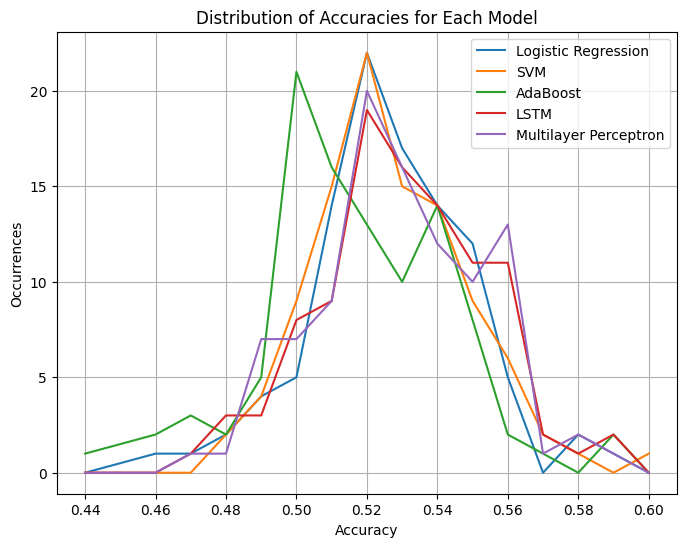

In [ ]:
accuracy_counts = {model_name: np.bincount(np.round(accuracy_models[model_name], decimals=2).astype(int)) for model_name in model_names}

# Prepare the x-axis values (accuracies)
accuracies = np.unique(np.concatenate([np.round(accuracy_models[model_name], decimals=2) for model_name in model_names]))
x_values = accuracies

# Prepare the y-axis values (occurrences) for each model
y_values = []
for model_name in model_names:
    model_accuracies = np.round(accuracy_models[model_name], decimals=2)
    y_values_model = [np.count_nonzero(model_accuracies == accuracy) if accuracy in model_accuracies else 0 for accuracy in accuracies]
    y_values.append(y_values_model)

# Plot the line chart
plt.figure(figsize=(8, 6))
for i in range(len(model_names)):
    plt.plot(x_values, y_values[i], label=model_names[i])
plt.xlabel('Accuracy')
plt.ylabel('Occurrences')
plt.title('Distribution of Accuracies for Each Model')
plt.legend()
plt.grid(True)
plt.show()







## The lines look a bit messy, normalize them

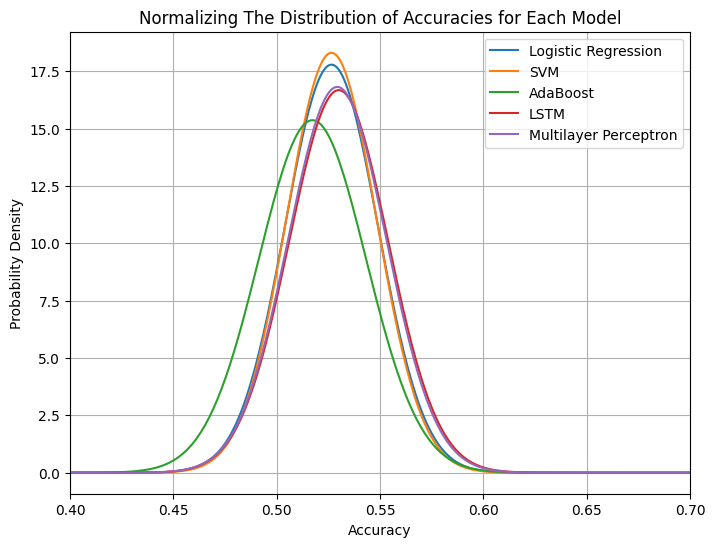

In [ ]:
from scipy.stats import norm

# Count the occurrences of each accuracy
accuracy_counts = {model_name: np.bincount(np.round(accuracy_models[model_name], decimals=2).astype(int)) for model_name in model_names}

# Prepare the x-axis values (accuracies)
accuracies = np.unique(np.concatenate([np.round(accuracy_models[model_name], decimals=2) for model_name in model_names]))
x_values = np.linspace(0, 1, 1000)

# Prepare the y-axis values (probability density) for each model
y_values = []
for model_name in model_names:
    model_accuracies = np.round(accuracy_models[model_name], decimals=2)
    y_values_model = norm.pdf(x_values, loc=np.mean(model_accuracies), scale=np.std(model_accuracies))
    y_values.append(y_values_model)

# Plot the line chart
plt.figure(figsize=(8, 6))
for i in range(len(model_names)):
    plt.plot(x_values, y_values[i], label=model_names[i])
plt.xlim(0.4, 0.7)
plt.xlabel('Accuracy')
plt.ylabel('Probability Density')
plt.title('Normalizing The Distribution of Accuracies for Each Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
echo "# prediction-of-bitcoin-and-nvidia" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/hesqi/prediction-of-bitcoin-and-nvidia.git
git push -u origin main

SyntaxError: ignored